<a href="https://colab.research.google.com/github/4deepprk/4deepprk.github.io/blob/master/D_109_LargeCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3
7. Exercises

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [3]:
transform_train = transforms.Compose([
                                      # CIFAR is of 3 x 3 but scaled up to 224 x 224
    transforms.RandomResizedCrop(224), # crop and resize (VGGNET and RESNET takes input of size 224 x 224)
    transforms.ToTensor(), # moving to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # mean and # standard deviation
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
num_classes = 10 # CIFAR has 10 classes

In [6]:
batch_size = 4 # 4 images in a batch for visualization

In [7]:
# loads the training data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
dataiter = iter(trainloader) # instantiating trainloader
images, labels = dataiter.next() # dataiter.next() looks at one batch (for 4 images)

print(images.shape)

print(images[1].shape) # prints the specific shape of image
print(labels[1].item()) # prints one of the 10 class

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
6


In [9]:
def imshow(img, title): # plot the image
    # pre-processing the image
    # multiply by 0.5 (standard deviation) and add by 0.5 (mean)
    # If we do not un-normalize the images then it will be too dark
    npimg = img.numpy() / 2 + 0.5 # convert the image into numpy and un-normalize
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 
    plt.title(title)
    plt.show()

In [10]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

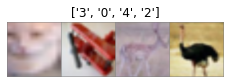

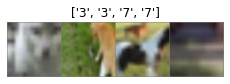

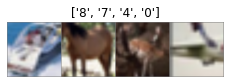

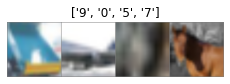

In [11]:
for i in range(4):
    show_batch_images(trainloader)

## Creating VGG-16

https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html

In [12]:
from torchvision import models

In [13]:
vgg = models.vgg16_bn() # instantiates the VGG16 layers completely without optimized parameters

In [14]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [15]:
print(vgg.features[0])
print(vgg.features[1])
print(vgg.features[3])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [16]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [17]:
# Modifying the output layer of classifier part to 10 neurons as opposed to 1000
# converting Linear(in_features=4096, out_features=1000, bias=True)
# to Linear(in_features=4096, out_features=10, bias=True)
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [18]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Train CIFAR10

In [19]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [20]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [21]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [28]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        # free up memory or deleting variables once completed to ensure the 
        # GPU memory not consumed much
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()

Iteration: 0/3125, Loss: 2.22
Iteration: 100/3125, Loss: 6.15
Iteration: 200/3125, Loss: 2.99
Iteration: 300/3125, Loss: 2.29
Iteration: 400/3125, Loss: 2.24
Iteration: 500/3125, Loss: 2.28
Iteration: 600/3125, Loss: 2.27
Iteration: 700/3125, Loss: 2.46


KeyboardInterrupt: ignored

### Freeze layers of Convolutional Operations (Transfer learning)

In [22]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [23]:
# Downloads the VGG16 layers as well as the optimized 138,357,544 parameters based on IMAGENET classification problem as well.
vgg = models.vgg16_bn(pretrained=True) # optimized weights and biases of pre-trained model for classification problem using IMAGENET dataset

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [24]:
# Frozen parameters - 138,357,544 parameters are there in VGG16
for param in vgg.parameters():
    param.requires_grad = False # do not update the weights and biases again (as they are already optimized based on IMAGENET classification problem)

In [25]:
# But we need to unfroze some of the layers because we need to train some layers as part of our specific problem in hand.
# Last layer (output layer which contains 1000 neurons because we have just downloaded pre-trained model VGG16 out of 
# IMAGENET classification problem containing 1000 classes)

final_in_features = vgg.classifier[6].in_features # delete the output layer containing 1000 neurons
# Unfroze the output layer such that it can be learned now (Redeclare the output layer as a new layer)
# What happens here is it creates new weights and biases parameter and by default set them to requires_grad = TRUE
vgg.classifier[6] = nn.Linear(final_in_features, num_classes) # replacing 10 neurons instead of 1000 neurons to deal with CIFAR problem that becomes only learnable parameters

In [26]:
# Therefore, around out of 138 million parameters only 40970 parameters are newly trainable (as rest of the parameters are already trained 
# from IMAGENET classificaiton problem)
# As output layer is unfrozen, now there are 4096*10 weights + 10 biases that needs to be learned
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape) # only classification parameters are learned (last output layer)

torch.Size([10, 4096])
torch.Size([10])


In [27]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [35]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        # free up memory or deleting variables once completed to ensure the 
        # GPU memory not consumed much    
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

Iteration: 0/3125, Loss: 2.35
Iteration: 100/3125, Loss: 2.16
Iteration: 200/3125, Loss: 1.04
Iteration: 300/3125, Loss: 1.77
Iteration: 400/3125, Loss: 1.29
Iteration: 500/3125, Loss: 1.80
Iteration: 600/3125, Loss: 1.69
Iteration: 700/3125, Loss: 1.98
Iteration: 800/3125, Loss: 2.34
Iteration: 900/3125, Loss: 1.94
Iteration: 1000/3125, Loss: 2.35
Iteration: 1100/3125, Loss: 2.73
Iteration: 1200/3125, Loss: 2.20
Iteration: 1300/3125, Loss: 2.26
Iteration: 1400/3125, Loss: 1.88
Iteration: 1500/3125, Loss: 1.36
Iteration: 1600/3125, Loss: 1.45


KeyboardInterrupt: ignored

### With model copies

In [28]:
import copy # deep copy of structures

In [37]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        # free up memory or deleting variables once completed to ensure the 
        # GPU memory not consumed much    
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 2.13
Iteration: 0/3125, Loss: 2.13
Min loss 1.81
Min loss 1.38
Min loss 1.36
Min loss 1.22
Min loss 0.99
Min loss 0.93
Iteration: 100/3125, Loss: 1.68
Min loss 0.58
Iteration: 200/3125, Loss: 2.06
Min loss 0.25
Iteration: 300/3125, Loss: 2.40
Iteration: 400/3125, Loss: 1.49
Iteration: 500/3125, Loss: 2.08
Iteration: 600/3125, Loss: 2.54
Iteration: 700/3125, Loss: 2.47
Iteration: 800/3125, Loss: 1.74
Iteration: 900/3125, Loss: 2.60
Iteration: 1000/3125, Loss: 1.59
Iteration: 1100/3125, Loss: 1.73
Iteration: 1200/3125, Loss: 2.42
Iteration: 1300/3125, Loss: 2.80
Iteration: 1400/3125, Loss: 1.66
Iteration: 1500/3125, Loss: 3.16
Iteration: 1600/3125, Loss: 3.31
Iteration: 1700/3125, Loss: 3.30
Iteration: 1800/3125, Loss: 2.44
Iteration: 1900/3125, Loss: 2.41
Iteration: 2000/3125, Loss: 3.53
Iteration: 2100/3125, Loss: 3.05
Iteration: 2200/3125, Loss: 1.66
Iteration: 2300/3125, Loss: 3.68
Iteration: 2400/3125, Loss: 2.12
Iteration: 2500/3125, Loss: 1.23
Iteration: 2600/3125, Loss: 

In [38]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

43.28 43.25


## ResNet Model

https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html

In [29]:
resnet = models.resnet18(pretrained=True) # optimized weights and biases of pre-trained model for classification problem using IMAGENET dataset

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [30]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
# Frozen parameters
for param in resnet.parameters():
    param.requires_grad = False # do not update the weights and biases again (as they are already optimized based on IMAGENET classification problem)

In [32]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [33]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [34]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

Min loss 2.55
Iteration: 0/3125, Loss: 2.55
Min loss 2.31
Min loss 2.18
Min loss 2.13
Min loss 1.91
Min loss 1.84
Min loss 1.77
Min loss 1.76
Min loss 1.70
Min loss 1.60
Iteration: 100/3125, Loss: 1.79
Min loss 1.60
Min loss 1.57
Min loss 1.49
Min loss 1.42
Min loss 1.40
Min loss 1.34
Min loss 1.34
Iteration: 200/3125, Loss: 1.82
Min loss 1.17
Min loss 0.94
Iteration: 300/3125, Loss: 1.42
Iteration: 400/3125, Loss: 1.69
Min loss 0.89
Iteration: 500/3125, Loss: 1.40
Min loss 0.82
Iteration: 600/3125, Loss: 1.28
Iteration: 700/3125, Loss: 1.51
Iteration: 800/3125, Loss: 1.69
Min loss 0.70
Iteration: 900/3125, Loss: 1.85
Min loss 0.58
Iteration: 1000/3125, Loss: 1.84
Iteration: 1100/3125, Loss: 1.28
Iteration: 1200/3125, Loss: 2.11
Iteration: 1300/3125, Loss: 1.34
Iteration: 1400/3125, Loss: 1.87
Iteration: 1500/3125, Loss: 1.26
Iteration: 1600/3125, Loss: 1.01
Iteration: 1700/3125, Loss: 1.37
Iteration: 1800/3125, Loss: 1.20
Iteration: 1900/3125, Loss: 1.27
Iteration: 2000/3125, Loss: 1.

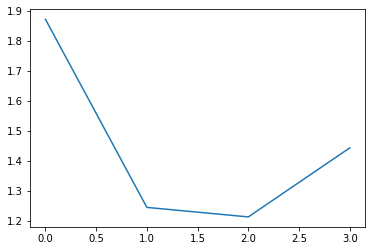

In [45]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        # free up memory or deleting variables once completed to ensure the 
        # GPU memory not consumed much
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [46]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

56.908 56.99


## Inception Model

https://pytorch.org/docs/master/_modules/torchvision/models/inception.html

In [35]:
inception = models.inception_v3(pretrained=True) # optimized weights and biases of pre-trained model for classification problem using IMAGENET dataset

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [36]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [37]:
# Frozen parameters
for param in inception.parameters():
    param.requires_grad = False # do not update the weights and biases again (as they are already optimized based on IMAGENET classification problem)

In [38]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [39]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [40]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [41]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [42]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), # as googlenet takes in 299 x 299
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), # as googlenet takes in 299 x 299
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [43]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [45]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [46]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs) # tuple as output as there are two outputs
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 3.12
Iteration: 0/3125, Loss: 3.12
Min loss 3.03
Min loss 3.03
Min loss 3.02
Min loss 2.95
Min loss 2.93
Min loss 2.87
Min loss 2.86
Min loss 2.77
Min loss 2.71
Min loss 2.59
Min loss 2.55
Min loss 2.53
Iteration: 100/3125, Loss: 2.60
Min loss 2.51
Min loss 2.32
Min loss 2.27
Min loss 2.20
Iteration: 200/3125, Loss: 2.65
Min loss 2.16
Min loss 1.78
Iteration: 300/3125, Loss: 2.38
Iteration: 400/3125, Loss: 2.62
Min loss 1.68
Iteration: 500/3125, Loss: 1.97
Iteration: 600/3125, Loss: 2.27
Iteration: 700/3125, Loss: 1.88
Min loss 1.62
Iteration: 800/3125, Loss: 2.52
Min loss 1.60
Iteration: 900/3125, Loss: 1.86
Min loss 1.56
Iteration: 1000/3125, Loss: 1.88
Min loss 1.38
Iteration: 1100/3125, Loss: 2.36
Min loss 1.31
Min loss 1.30
Iteration: 1200/3125, Loss: 2.04
Iteration: 1300/3125, Loss: 1.91
Iteration: 1400/3125, Loss: 2.00
Iteration: 1500/3125, Loss: 1.75
Min loss 1.29
Min loss 1.25
Iteration: 1600/3125, Loss: 1.94
Iteration: 1700/3125, Loss: 1.74
Iteration: 1800/3125, Loss

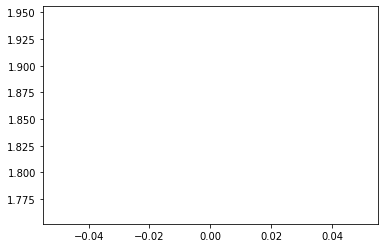

In [47]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        # more importance given to complete loss and less importance to auxillary loss
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        # free up memory or deleting variables once completed to ensure the 
        # GPU memory not consumed much    
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [48]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

45.66 45.04


## Exercises

1. Structure the above code into a series of functions and then call each model

2. Try out different hyperparameter combinations and try to achieve published results on different networks

3. Try out the CIFAR100 and STL10 datasets

4. Try out another model - SqueezeNet

5. Try training multiple layers and not just the last one